In [3]:
# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from OA_utils.data_utils import *
from OA_utils.eval_utils import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from OA_lstm import LSTMModel
from OA_cnnlstm import CNNLSTMModel
from OA_lstmattn import LSTMAttentionModel
from OA_transformer import TransformerModel

In [4]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [5]:
#data_dir = "C:\\Users\\bakel\\Desktop\\GRFMuscleModel\\Old_Young_Walking_Data\\"
data_dir = "/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/"

train_data = np.load(data_dir + 'mixed_train_data.npz')
val_data = np.load(data_dir + 'mixed_val_data.npz')
test_data = np.load(data_dir + 'mixed_test_data.npz')

grf_labels = ['GRF_x', 'GRF_y', 'GRF_z']
muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 
                 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']
muscle_titles = ['Tibialis Posterior', 'Tibialis Anterior', 'Extensor Digitorum Longus', 'Extensor Hallucis Longus', 
                 'Flexor Digitorum Longus', 'Flexor Hallucis Longus', 'Peroneus Brevis', 'Peroneus Longus', 'Achilles']
muscle_abbrevs = ['Tib Post', 'Tib Ant', 'EDL', 'EHL', 'FDL', 'FHL', 'Per Brevis', 'Per Long', 'Achilles']

grf_dict = {0: 'GRF_x', 1: 'GRF_y', 2: 'GRF_z'}
muscle_dict = {0: 'tibpost', 1: 'tibant', 2: 'edl', 3: 'ehl', 4: 'fdl', 5: 'fhl', 6: 'perbrev', 7: 'perlong', 8: 'achilles'}

In [6]:
X_train = train_data['X_train']
y_train = train_data['y_train']
X_val = val_data['X_val']
y_val = val_data['y_val']
X_test = test_data['X_test']
y_test = test_data['y_test']

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1153, 100, 3)
y_train shape: (1153, 100, 9)
X_val shape: (142, 100, 3)
y_val shape: (142, 100, 9)
X_test shape: (116, 100, 3)
y_test shape: (116, 100, 9)


In [7]:
# convert test data to torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [8]:
lstm_model = LSTMModel(input_size=3, 
                       hidden_size=256, 
                       num_layers=3, 
                       output_size=9, 
                       dropout=0.1002698879594955)

lstm_model.load_state_dict(torch.load('../models/Mixed_lstm.pth', map_location=device, weights_only=True))

lstm_model.to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(lstm_model.parameters(), 
#                        lr=0.0004070688993179255, 
#                        weight_decay=4.278679617413207e-05)

LSTMModel(
  (lstm): LSTM(3, 256, num_layers=3, batch_first=True, dropout=0.1002698879594955)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [9]:
lstm_loss, lstm_pred_tensor = eval_model(lstm_model, X_test_tensor, y_test_tensor)
print(f"LSTM Loss: {lstm_loss}")

LSTM Loss: 8523.939453125


In [10]:
# y_test = y_test_tensor.cpu().numpy()
lstm_pred = lstm_pred_tensor.cpu().numpy()

lstm_rrmse = calc_rrmse_muscle(y_test, lstm_pred)

tibpost: 0.1404
tibant: 0.1102
edl: 0.1090
ehl: 0.0763
fdl: 0.1425
fhl: 0.1592
perbrev: 0.1255
perlong: 0.1043
achilles: 0.0601


In [12]:
lstm_norm_mae, lstm_overall_norm_mae = calc_mae_muscle_normalized_mass(y_test, lstm_pred)

tibpost: Normalized MAE:2.0170
tibant: Normalized MAE:1.3560
edl: Normalized MAE:0.4515
ehl: Normalized MAE:0.0712
fdl: Normalized MAE:0.0973
fhl: Normalized MAE:0.4210
perbrev: Normalized MAE:0.2866
perlong: Normalized MAE:0.9242
achilles: Normalized MAE:5.1718
Overall MAE Normalized by bodyweight: 1.1996009299178991


In [11]:
lstm_mae = calc_mae_muscle(y_test, lstm_pred)

tibpost: 77.9354
tibant: 40.3633
edl: 12.3520
ehl: 1.8946
fdl: 3.6679
fhl: 17.0893
perbrev: 9.6256
perlong: 29.6304
achilles: 164.2676


In [12]:
lstm_r2 = calc_r2_muscle(y_test, lstm_pred)

tibpost: 0.4522
tibant: 0.7018
edl: 0.3630
ehl: 0.5684
fdl: 0.4711
fhl: 0.3626
perbrev: -0.0004
perlong: 0.0455
achilles: 0.8949


In [13]:
cnnlstm_model = CNNLSTMModel(input_size=3, 
                             hidden_size=256,
                             num_layers=2, 
                             output_size=9, 
                             dropout= 0.3391463727944943)

cnnlstm_model.load_state_dict(torch.load('../models/Mixed_cnn-lstm.pth', map_location=device, weights_only=True))

cnnlstm_model.to(device)

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3391463727944943)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [14]:
cnnlstm_loss, cnnlstm_pred_tensor = eval_model(cnnlstm_model, X_test_tensor, y_test_tensor)
print(f"CNN-LSTM Loss: {cnnlstm_loss}")

CNN-LSTM Loss: 18218.705078125


In [15]:
# y_test = y_test_tensor.cpu().numpy()
cnnlstm_pred = cnnlstm_pred_tensor.cpu().numpy()

cnnlstm_rrmse = calc_rrmse_muscle(y_test, cnnlstm_pred)

tibpost: 0.1583
tibant: 0.1122
edl: 0.1071
ehl: 0.0754
fdl: 0.1773
fhl: 0.1683
perbrev: 0.1269
perlong: 0.1070
achilles: 0.0938


In [17]:
cnnlstm_norm_mae, cnnlstm_overall_norm_mae = calc_mae_muscle_normalized_mass(y_test, cnnlstm_pred)

tibpost: Normalized MAE:2.5957
tibant: Normalized MAE:1.3736
edl: Normalized MAE:0.4321
ehl: Normalized MAE:0.0652
fdl: Normalized MAE:0.1522
fhl: Normalized MAE:0.5306
perbrev: Normalized MAE:0.3071
perlong: Normalized MAE:0.9487
achilles: Normalized MAE:8.7862
Overall MAE Normalized by bodyweight: 1.687932986610552


In [18]:
cnnlstm_mae = calc_mae_muscle(y_test, cnnlstm_pred)

tibpost: 89.8036
tibant: 43.0780
edl: 11.5108
ehl: 1.7222
fdl: 4.7638
fhl: 18.8485
perbrev: 9.8970
perlong: 30.5097
achilles: 281.1154


In [19]:
cnnlstm_r2 = calc_r2_muscle(y_test, cnnlstm_pred)

tibpost: 0.3034
tibant: 0.6914
edl: 0.3854
ehl: 0.5786
fdl: 0.1811
fhl: 0.2879
perbrev: -0.0225
perlong: -0.0039
achilles: 0.7443


In [20]:
lstmattn_model = LSTMAttentionModel(input_size=3, 
                                    hidden_size=256, 
                                    num_layers=3, 
                                    num_heads=8, 
                                    output_size=9, 
                                    lstm_dropout= 0.3310440233604349, 
                                    attn_dropout= 0.1876350446397092)

lstmattn_model.load_state_dict(torch.load('../models/Mixed_lstm-attn.pth', map_location=device, weights_only=True))

lstmattn_model.to(device)

LSTMAttentionModel(
  (lstm): LSTM(3, 256, num_layers=3, batch_first=True, dropout=0.3310440233604349)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [21]:
lstmattn_loss, lstmattn_pred_tensor = eval_model(lstmattn_model, X_test_tensor, y_test_tensor)
print(f"LSTM-Attention Loss: {lstmattn_loss}")

LSTM-Attention Loss: 9347.404296875


In [22]:
lstmattn_pred = lstmattn_pred_tensor.cpu().numpy()

lstmattn_rrmse = calc_rrmse_muscle(y_test, lstmattn_pred)

tibpost: 0.1343
tibant: 0.1175
edl: 0.1116
ehl: 0.0842
fdl: 0.1424
fhl: 0.1527
perbrev: 0.1393
perlong: 0.1092
achilles: 0.0638


In [23]:
lstmattn_norm_mae, lstmattn_overall_norm_mae = calc_mae_muscle_normalized_mass(y_test, lstmattn_pred)

tibpost: Normalized MAE:1.9874
tibant: Normalized MAE:1.4347
edl: Normalized MAE:0.4694
ehl: Normalized MAE:0.0822
fdl: Normalized MAE:0.1024
fhl: Normalized MAE:0.4287
perbrev: Normalized MAE:0.3126
perlong: Normalized MAE:0.9880
achilles: Normalized MAE:5.5651
Overall MAE Normalized by bodyweight: 1.2633933230134748


In [32]:
lstmattn_mae = calc_mae_muscle(y_test, lstmattn_pred)

tibpost: 74.8605
tibant: 45.1720
edl: 13.7044
ehl: 2.2939
fdl: 3.6970
fhl: 16.7756
perbrev: 11.5646
perlong: 32.6291
achilles: 190.6608


In [25]:
lstmattn_r2= calc_r2_muscle(y_test, lstmattn_pred)

tibpost: 0.4986
tibant: 0.6614
edl: 0.3328
ehl: 0.4742
fdl: 0.4719
fhl: 0.4139
perbrev: -0.2318
perlong: -0.0448
achilles: 0.8816


In [26]:
transformer_model = TransformerModel(input_dim=3,
                                     output_dim=9, 
                                     d_model=64, 
                                     nhead=4, 
                                     num_encoder_layers=4, 
                                     dim_feedforward=64, 
                                     dropout= 0.03146693103890347)

transformer_model.load_state_dict(torch.load('../models/Mixed_transformer.pth', map_location=device, weights_only=True))

transformer_model.to(device)

TransformerModel(
  (input_embedding): Linear(in_features=3, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.03146693103890347, inplace=False)
        (linear2): Linear(in_features=64, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.03146693103890347, inplace=False)
        (dropout2): Dropout(p=0.03146693103890347, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_features=9, bias=True)
)

In [27]:
transformer_loss, transformer_pred_tensor = eval_model(transformer_model, X_test_tensor, y_test_tensor)
print(f"Transformer Loss: {transformer_loss}")

Transformer Loss: 8513.1728515625


In [28]:
transformer_pred = transformer_pred_tensor.cpu().numpy()

transformer_rrmse = calc_rrmse_muscle(y_test, transformer_pred)

tibpost: 0.1520
tibant: 0.1173
edl: 0.1136
ehl: 0.0797
fdl: 0.1661
fhl: 0.1690
perbrev: 0.1293
perlong: 0.1062
achilles: 0.0588


In [29]:
transformer_norm_mae, transformer_overall_norm_mae = calc_mae_muscle_normalized_mass(y_test, transformer_pred)

tibpost: Normalized MAE:2.1525
tibant: Normalized MAE:1.4079
edl: Normalized MAE:0.4939
ehl: Normalized MAE:0.0727
fdl: Normalized MAE:0.1201
fhl: Normalized MAE:0.4492
perbrev: Normalized MAE:0.2944
perlong: Normalized MAE:0.9420
achilles: Normalized MAE:5.1653
Overall MAE Normalized by bodyweight: 1.2331246275372882


In [39]:
transformer_mae = calc_mae_muscle(y_test, transformer_pred)

tibpost: 82.2745
tibant: 43.2513
edl: 13.8258
ehl: 1.9669
fdl: 4.3401
fhl: 18.0393
perbrev: 9.7323
perlong: 30.5768
achilles: 175.0786


In [40]:
transformer_r2 = calc_r2_muscle(y_test, transformer_pred)

tibpost: 0.3583
tibant: 0.6622
edl: 0.3088
ehl: 0.5296
fdl: 0.2814
fhl: 0.2819
perbrev: -0.0624
perlong: 0.0121
achilles: 0.8995


In [41]:
lstm_rmse_overall = calc_rmse_overall(y_test, lstm_pred)
print(f"LSTM RMSE Overall: {lstm_rmse_overall}")

cnnlstm_rmse_overall = calc_rmse_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RMSE Overall: {cnnlstm_rmse_overall}")

lstmattn_rmse_overall = calc_rmse_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RMSE Overall: {lstmattn_rmse_overall}")

transformer_rmse_overall = calc_rmse_overall(y_test, transformer_pred)
print(f"Transformer RMSE Overall: {transformer_rmse_overall}")

LSTM RMSE Overall: 92.32231415838186
CNN-LSTM RMSE Overall: 134.9766805818326
LSTM-Attention RMSE Overall: 96.68197136103824
Transformer RMSE Overall: 92.26685592010557


In [42]:
lstm_rrmse_overall = calc_rrmse_overall(y_test, lstm_pred)
print(f"LSTM RRMSE Overall: {lstm_rrmse_overall}")

cnnlstm_rrmse_overall = calc_rrmse_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RRMSE Overall: {cnnlstm_rrmse_overall}")

lstmattn_rrmse_overall = calc_rrmse_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RRMSE Overall: {lstmattn_rrmse_overall}")

transformer_rrmse_overall = calc_rrmse_overall(y_test, transformer_pred)
print(f"Transformer RRMSE Overall: {transformer_rrmse_overall}")

LSTM RRMSE Overall: 0.022491689627072053
CNN-LSTM RRMSE Overall: 0.032883205259899774
LSTM-Attention RRMSE Overall: 0.02355379533333022
Transformer RRMSE Overall: 0.022478178814502574


In [43]:
lstm_rrmse_weighted = calc_rrmse_weighted(y_test, lstm_pred)
print(f"LSTM RRMSE Weighted: {lstm_rrmse_weighted}")

cnnlstm_rrmse_weighted = calc_rrmse_weighted(y_test, cnnlstm_pred)
print(f"CNN-LSTM RRMSE Weighted: {cnnlstm_rrmse_weighted}")

lstmattn_rrmse_weighted = calc_rrmse_weighted(y_test, lstmattn_pred)
print(f"LSTM-Attention RRMSE Weighted: {lstmattn_rrmse_weighted}")

transformer_rrmse_weighted = calc_rrmse_weighted(y_test, transformer_pred)
print(f"Transformer RRMSE Weighted: {transformer_rrmse_weighted}")

LSTM RRMSE Weighted: 0.08265233746378636
CNN-LSTM RRMSE Weighted: 0.1066545635174648
LSTM-Attention RRMSE Weighted: 0.08557157934673047
Transformer RRMSE Weighted: 0.08450552703696419


In [44]:
lstm_rmspe = calc_rmspe_overall(y_test, lstm_pred)
print(f"LSTM RMSPE: {lstm_rmspe}")

cnnlstm_rmspe = calc_rmspe_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RMSPE: {cnnlstm_rmspe}")

lstmattn_rmspe = calc_rmspe_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RMSPE: {lstmattn_rmspe}")

transformer_rmspe = calc_rmspe_overall(y_test, transformer_pred)
print(f"Transformer RMSPE: {transformer_rmspe}")

LSTM RMSPE: 0.80713621818358
CNN-LSTM RMSPE: 0.9819596413869652
LSTM-Attention RMSPE: 0.9511700691003905
Transformer RMSPE: 0.9262734448649799


In [45]:
lstm_mae_overall = calc_mae_overall(y_test, lstm_pred)
print(f"LSTM MAE Overall: {lstm_mae_overall}")

cnnlstm_mae_overall = calc_mae_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM MAE Overall: {cnnlstm_mae_overall}")

lstmattn_mae_overall = calc_mae_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention MAE Overall: {lstmattn_mae_overall}")

transformer_mae_overall = calc_mae_overall(y_test, transformer_pred)
print(f"Transformer MAE Overall: {transformer_mae_overall}")

LSTM MAE Overall: 39.64734463146641
CNN-LSTM MAE Overall: 54.58322628499097
LSTM-Attention MAE Overall: 43.48419537271967
Transformer MAE Overall: 42.120613294807654


In [46]:
lstm_mae_weighted = calc_mae_weighted(y_test, lstm_pred)
print(f"LSTM MAE Weighted: {lstm_mae_weighted}")

cnnlstm_mae_weighted = calc_mae_weighted(y_test, cnnlstm_pred)
print(f"CNN-LSTM MAE Weighted: {cnnlstm_mae_weighted}")

lstmattn_mae_weighted = calc_mae_weighted(y_test, lstmattn_pred)
print(f"LSTM-Attention MAE Weighted: {lstmattn_mae_weighted}")

transformer_mae_weighted = calc_mae_weighted(y_test, transformer_pred)
print(f"Transformer MAE Weighted: {transformer_mae_weighted}")

LSTM MAE Weighted: 0.056027752872394095
CNN-LSTM MAE Weighted: 0.0771344346437337
LSTM-Attention MAE Weighted: 0.06144980893030676
Transformer MAE Weighted: 0.05952285920914329


In [47]:
lstm_r2_overall = calc_r2_overall(y_test, lstm_pred)
print(f"LSTM R2: {lstm_r2_overall}")

cnnlstm_r2_overall = calc_r2_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM R2: {cnnlstm_r2_overall}")

lstmattn_r2_overall = calc_r2_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention R2: {lstmattn_r2_overall}")

transformer_r2_overall = calc_r2_overall(y_test, transformer_pred)
print(f"Transformer R2: {transformer_r2_overall}")

LSTM R2: 0.9344795206994773
CNN-LSTM R2: 0.8599506205584632
LSTM-Attention R2: 0.9281453801530287
Transformer R2: 0.9345582136788473


In [48]:
from sklearn.metrics import r2_score

lstm_r2_overall = r2_score(y_test.flatten(), lstm_pred.flatten())
print(f"LSTM R2: {lstm_r2_overall}")

cnnlstm_r2_overall = r2_score(y_test.flatten(), cnnlstm_pred.flatten())
print(f"CNN-LSTM R2: {cnnlstm_r2_overall}")

lstmattn_r2_overall = r2_score(y_test.flatten(), lstmattn_pred.flatten())
print(f"LSTM-Attention R2: {lstmattn_r2_overall}")

transformer_r2_overall = r2_score(y_test.flatten(), transformer_pred.flatten())
print(f"Transformer R2: {transformer_r2_overall}")

LSTM R2: 0.9344795206994773
CNN-LSTM R2: 0.8599506205584632
LSTM-Attention R2: 0.9281453801530287
Transformer R2: 0.9345582136788473


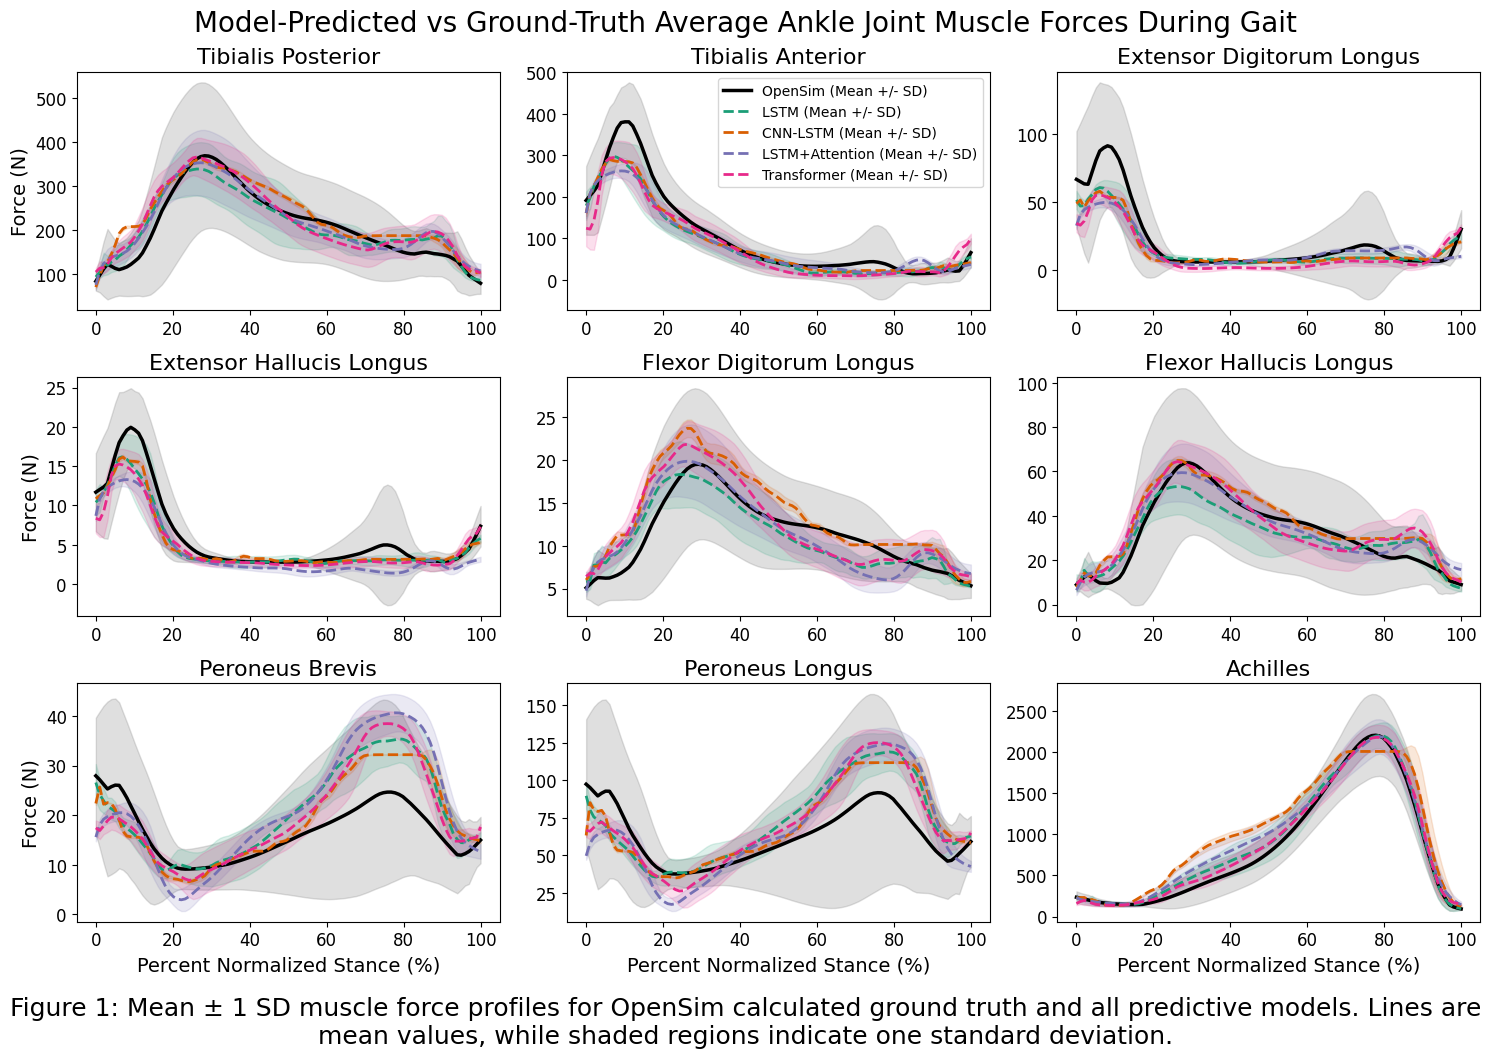

In [49]:
# Ground truth stats
true_mean = np.mean(y_test, axis=0)      
true_std  = np.std(y_test, axis=0)      

# Model stats
lstm_mean  = np.mean(lstm_pred, axis=0)
lstm_std   = np.std(lstm_pred, axis=0)

cnn_mean   = np.mean(cnnlstm_pred, axis=0)
cnn_std    = np.std(cnnlstm_pred, axis=0)

attn_mean  = np.mean(lstmattn_pred, axis=0)
attn_std   = np.std(lstmattn_pred, axis=0)

trans_mean = np.mean(transformer_pred, axis=0)
trans_std  = np.std(transformer_pred, axis=0)

pred_means = [lstm_mean, cnn_mean, attn_mean, trans_mean]
pred_stds  = [lstm_std, cnn_std, attn_std, trans_std]
perc_stance = np.linspace(0, 100, 100)
model_labels = ['LSTM (Mean +/- SD)', 'CNN-LSTM (Mean +/- SD)', 'LSTM+Attention (Mean +/- SD)', 'Transformer (Mean +/- SD)']
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']  

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(perc_stance, true_mean[:, i], label='OpenSim (Mean +/- SD)', color='black', linewidth=2.5)
    ax.fill_between(
        perc_stance,
        true_mean[:, i] - true_std[:, i],
        true_mean[:, i] + true_std[:, i],
        color='gray', alpha=0.25
    )
    for j, (pred_m, pred_s) in enumerate(zip(pred_means, pred_stds)):
        
        ax.plot(perc_stance, pred_m[:, i],
                label=model_labels[j], color=colors[j], linewidth=2, linestyle = '--')

        ax.fill_between(
            perc_stance,
            pred_m[:, i] - pred_s[:, i],
            pred_m[:, i] + pred_s[:, i],
            color=colors[j], alpha=0.15
        )

    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance (%)', fontsize=14)
    if i % 3 == 0:
        ax.set_ylabel('Force (N)', fontsize=14)

    ax.set_title(muscle_titles[i], fontsize=16)
    if i == 1:
        ax.legend(loc='upper right', fontsize=10, frameon=True)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
handles, labels = axes[0].get_legend_handles_labels()

caption_text = (
    "Figure 1: Mean ± 1 SD muscle force profiles for OpenSim calculated ground truth and all predictive models. "
    "Lines are mean values, while shaded regions indicate one standard deviation."
)

plt.figtext(
    0.5, -0.05,                 
    caption_text,
    wrap=True,
    ha='center',
    fontsize=18
)

plt.suptitle('Model-Predicted vs Ground-Truth Average Ankle Joint Muscle Forces During Gait', fontsize = 20)
plt.tight_layout()
plt.show()


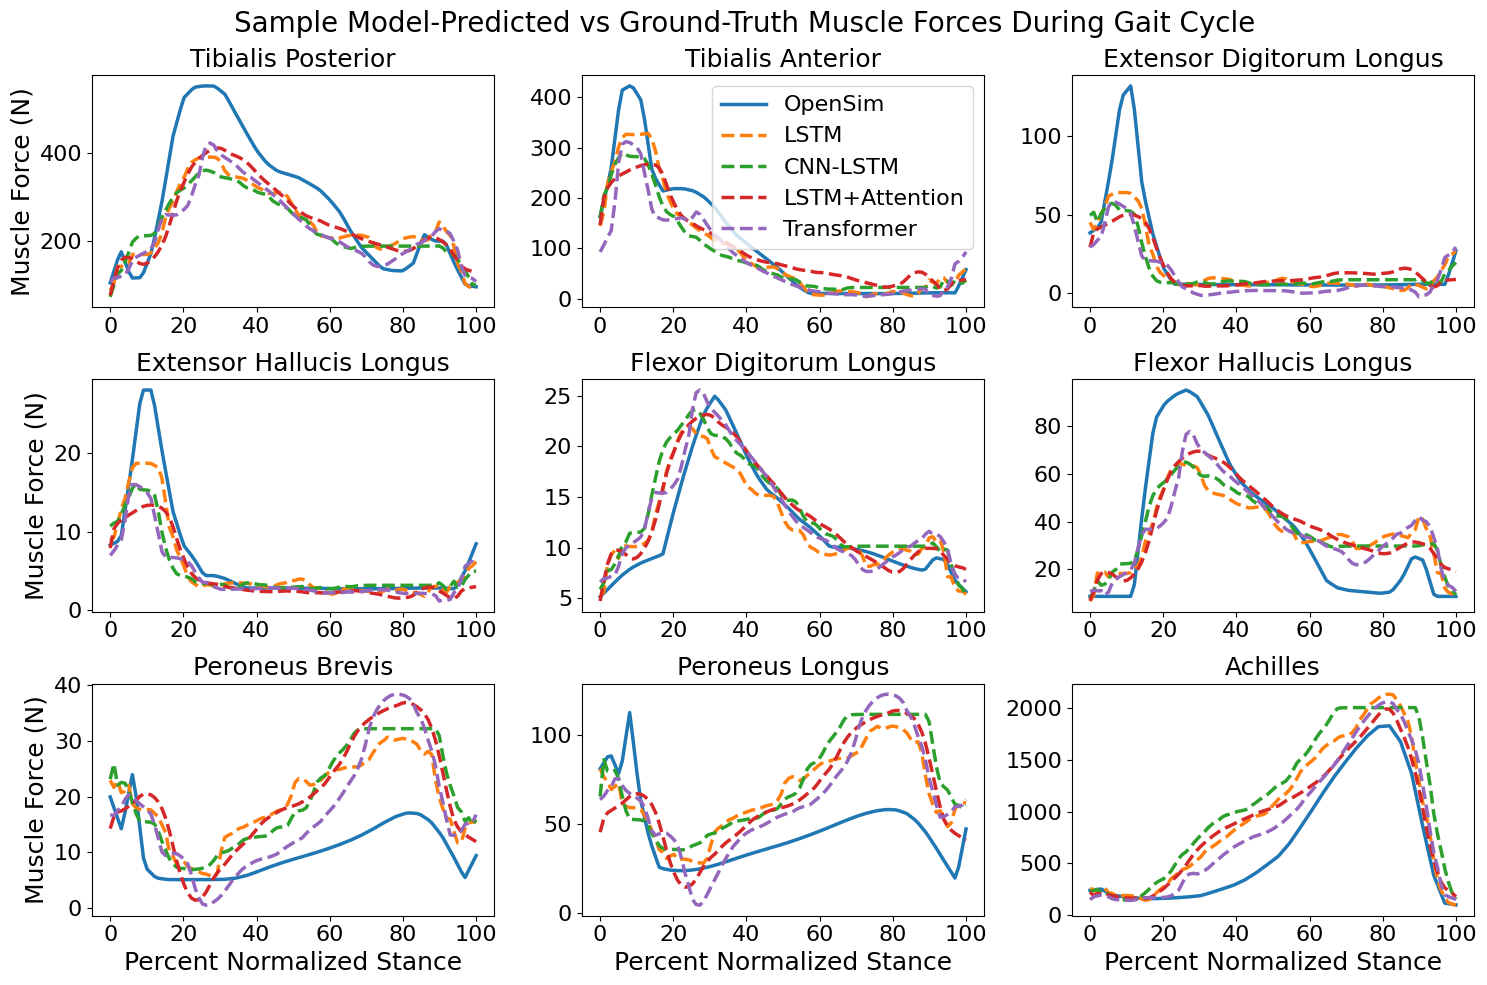

In [50]:
sample_idx = 69

preds = [lstm_pred[sample_idx], cnnlstm_pred[sample_idx], lstmattn_pred[sample_idx], transformer_pred[sample_idx]]
true = y_test[sample_idx]

perc_stance = np.linspace(0, 100, 100)

model_labels = ['LSTM', 'CNN-LSTM', 'LSTM+Attention', 'Transformer']

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(perc_stance, true[:, i], label='OpenSim', linewidth=2.5)
    
    for j, pred in enumerate(preds):
        ax.plot(perc_stance, pred[:, i], label=model_labels[j], linewidth=2.5, linestyle='--')
        
    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance', fontsize=18)
        
    if i % 3 == 0:
        ax.set_ylabel('Muscle Force (N)', fontsize=18)
        
    ax.set_title(muscle_titles[i], fontsize=18)
    if i == 1:
        ax.legend(loc='upper right', fontsize=16, frameon=True)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    handles, labels = axes[0].get_legend_handles_labels()

# fig.legend(
#     handles, labels,
#     loc='center left',      
#     ncol=1,                    
#     fontsize=16,
#     frameon=False,
#     bbox_to_anchor=(1, 0.5)  
# )

plt.suptitle('Sample Model-Predicted vs Ground-Truth Muscle Forces During Gait Cycle', fontsize = 20)
plt.tight_layout()
plt.show()


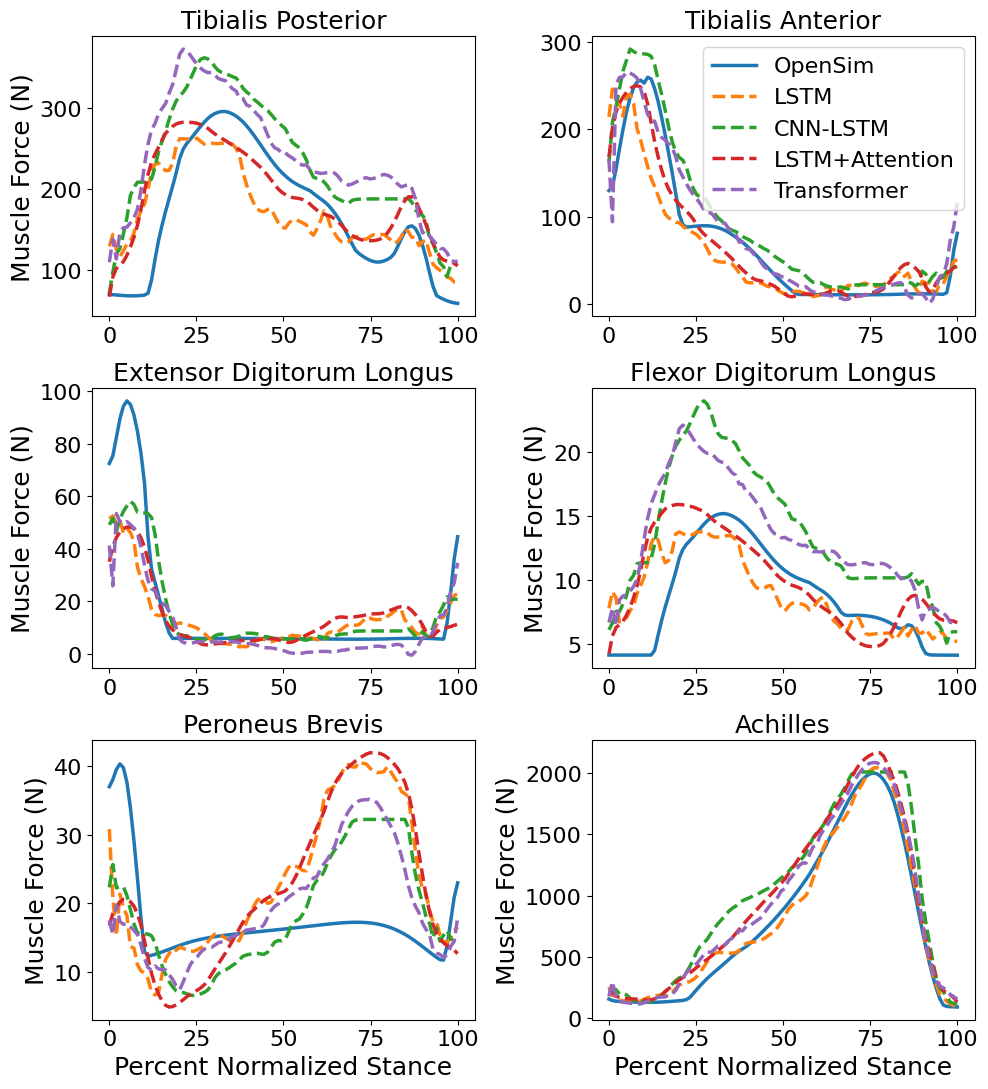

In [51]:
sample_idx = 0

preds = [lstm_pred[sample_idx], cnnlstm_pred[sample_idx], lstmattn_pred[sample_idx], transformer_pred[sample_idx]]
true = y_test[sample_idx]

perc_stance = np.linspace(0, 100, 100)

model_labels = ['LSTM', 'CNN-LSTM', 'LSTM+Attention', 'Transformer']

plot_idx = [0, 1, 2, 4, 6, 8]

fig, axes = plt.subplots(3, 2, figsize=(10, 11))  # Create subplots for 9 muscles
axes = axes.flatten()

for i, ax in zip(plot_idx, axes):
    ax.plot(perc_stance, true[:, i], label='OpenSim', linewidth=2.5)
    
    for j, pred in enumerate(preds):
        ax.plot(perc_stance, pred[:, i], label=model_labels[j], linewidth=2.5, linestyle='--')
        
    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance', fontsize=18)
        
    if i % 2 == 0:
        ax.set_ylabel('Muscle Force (N)', fontsize=18)
        
    ax.set_title(muscle_titles[i], fontsize=18)
    if i == 1:
        ax.legend(loc='upper right', fontsize=16, frameon=True)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.show()


In [52]:
rrmse_muscle_dict = {'LSTM': lstm_rrmse, 'CNN-LSTM': cnnlstm_rrmse, 'LSTM+Attention': lstmattn_rrmse, 'Transformer': transformer_rrmse}
rrmse_overall_dict = {'LSTM': lstm_rrmse_weighted, 'CNN-LSTM': cnnlstm_rrmse_weighted, 'LSTM+Attention': lstmattn_rrmse_weighted, 'Transformer': transformer_rrmse_weighted}

rrmse_table = generate_latex_table(rrmse_muscle_dict, rrmse_overall_dict, muscle_titles)
print(rrmse_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 0.1404 & 0.1583 & 0.1343 & 0.1520 \\
{Tibialis Anterior} & 0.1102 & 0.1122 & 0.1175 & 0.1173 \\
{Extensor Digitorum Longus} & 0.1090 & 0.1071 & 0.1116 & 0.1136 \\
{Extensor Hallucis Longus} & 0.0763 & 0.0754 & 0.0842 & 0.0797 \\
{Flexor Digitorum Longus} & 0.1425 & 0.1773 & 0.1424 & 0.1661 \\
{Flexor Hallucis Longus} & 0.1592 & 0.1683 & 0.1527 & 0.1690 \\
{Peroneus Brevis} & 0.1255 & 0.1269 & 0.1393 & 0.1293 \\
{Peroneus Longus} & 0.1043 & 0.1070 & 0.1092 & 0.1062 \\
{Achilles} & 0.0601 & 0.0938 & 0.0638 & 0.0588 \\
\midrule
Overall & 0.0827 & 0.1067 & 0.0856 & 0.0845 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [53]:
mae_muscle_dict = {'LSTM': lstm_mae, 'CNN-LSTM': cnnlstm_mae, 'LSTM+Attention': lstmattn_mae, 'Transformer': transformer_mae}
mae_overall_dict = {'LSTM': lstm_mae_weighted, 'CNN-LSTM': cnnlstm_mae_weighted, 'LSTM+Attention': lstmattn_mae_weighted, 'Transformer': transformer_mae_weighted}

mae_table = generate_latex_table(mae_muscle_dict, mae_overall_dict, muscle_titles)
print(mae_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 77.9354 & 89.8036 & 74.8605 & 82.2745 \\
{Tibialis Anterior} & 40.3633 & 43.0780 & 45.1720 & 43.2513 \\
{Extensor Digitorum Longus} & 12.3520 & 11.5108 & 13.7044 & 13.8258 \\
{Extensor Hallucis Longus} & 1.8946 & 1.7222 & 2.2939 & 1.9669 \\
{Flexor Digitorum Longus} & 3.6679 & 4.7638 & 3.6970 & 4.3401 \\
{Flexor Hallucis Longus} & 17.0893 & 18.8485 & 16.7756 & 18.0393 \\
{Peroneus Brevis} & 9.6256 & 9.8970 & 11.5646 & 9.7323 \\
{Peroneus Longus} & 29.6304 & 30.5097 & 32.6291 & 30.5768 \\
{Achilles} & 164.2676 & 281.1154 & 190.6608 & 175.0786 \\
\midrule
Overall & 0.0560 & 0.0771 & 0.0614 & 0.0595 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [54]:
r2_muscle_dict = {'LSTM': lstm_r2, 'CNN-LSTM': cnnlstm_r2, 'LSTM+Attention': lstmattn_r2, 'Transformer': transformer_r2}
r2_overall_dict = {'LSTM': lstm_r2_overall, 'CNN-LSTM': cnnlstm_r2_overall, 'LSTM+Attention': lstmattn_r2_overall, 'Transformer': transformer_r2_overall}

r2_table = generate_latex_table(r2_muscle_dict, r2_overall_dict, muscle_titles)
print(r2_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 0.4522 & 0.3034 & 0.4986 & 0.3583 \\
{Tibialis Anterior} & 0.7018 & 0.6914 & 0.6614 & 0.6622 \\
{Extensor Digitorum Longus} & 0.3630 & 0.3854 & 0.3328 & 0.3088 \\
{Extensor Hallucis Longus} & 0.5684 & 0.5786 & 0.4742 & 0.5296 \\
{Flexor Digitorum Longus} & 0.4711 & 0.1811 & 0.4719 & 0.2814 \\
{Flexor Hallucis Longus} & 0.3626 & 0.2879 & 0.4139 & 0.2819 \\
{Peroneus Brevis} & -0.0004 & -0.0225 & -0.2318 & -0.0624 \\
{Peroneus Longus} & 0.0455 & -0.0039 & -0.0448 & 0.0121 \\
{Achilles} & 0.8949 & 0.7443 & 0.8816 & 0.8995 \\
\midrule
Overall & 0.9345 & 0.8600 & 0.9281 & 0.9346 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [55]:
norm_mae_muscle_dict = {'LSTM': lstm_norm_mae, 'CNN-LSTM': cnnlstm_norm_mae, 'LSTM+Attention': lstmattn_norm_mae, 'Transformer': transformer_norm_mae}
norm_mae_overall_dict = {'LSTM': lstm_overall_norm_mae, 'CNN-LSTM': cnnlstm_overall_norm_mae, 'LSTM+Attention': lstmattn_overall_norm_mae, 'Transformer': transformer_overall_norm_mae}

In [56]:
# Settings
muscles = [muscle_abbrevs[i] for i in range(9)]  # Labels for muscles
muscles += ['Overall']  # Add overall R^2
models = list(r2_muscle_dict.keys())
x = np.arange(len(muscles))  # Muscle indices for the x-axis

bar_width = 0.2  # Width of each bar
offsets = np.arange(len(models)) * bar_width  # Offsets for grouped bars

colors = {
    'LSTM': 'C1',
    'CNN-LSTM': 'C2',
    'LSTM+Attention': 'C3',
    'Transformer': 	'C4'
}

for model in models:
    r2_muscle_dict[model] = list(r2_muscle_dict[model])  # Ensure it's a list
    r2_muscle_dict[model].append(r2_overall_dict[model])  # Append overall R^2

    rrmse_muscle_dict[model] = list(rrmse_muscle_dict[model])  # Ensure it's a list
    rrmse_muscle_dict[model].append(rrmse_overall_dict[model])  # Append overall RRMSE

    mae_muscle_dict[model] = list(mae_muscle_dict[model])
    mae_muscle_dict[model].append(mae_overall_dict[model])

    norm_mae_muscle_dict[model] = list(norm_mae_muscle_dict[model])  
    norm_mae_muscle_dict[model].append(norm_mae_overall_dict[model])  


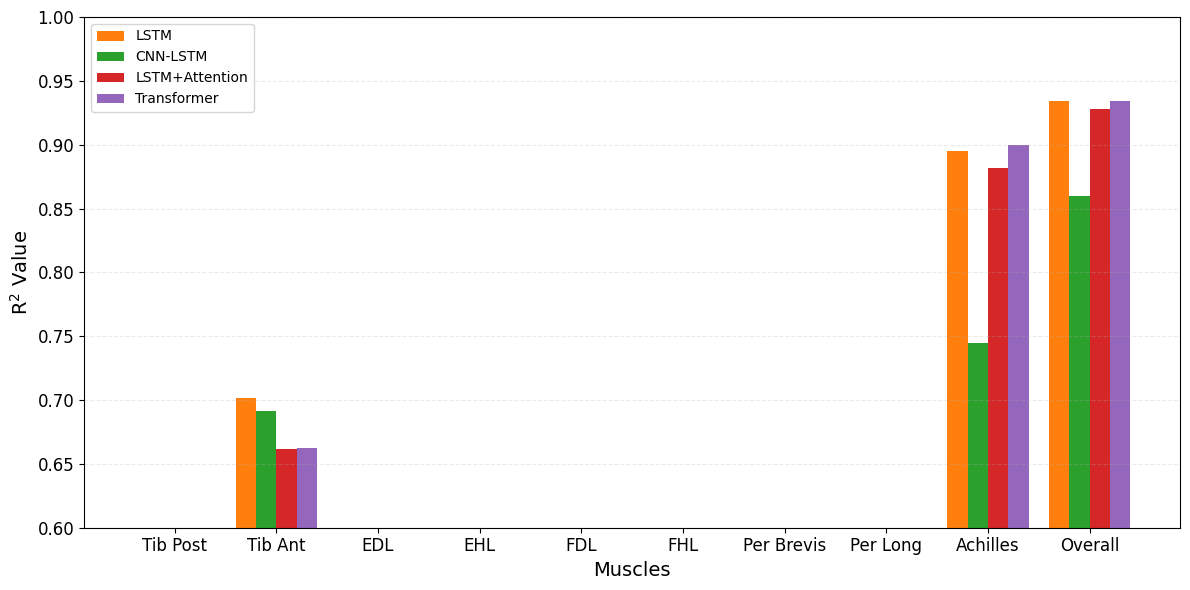

In [57]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], r2_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('R$^2$ Value', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.tight_layout()
plt.show()

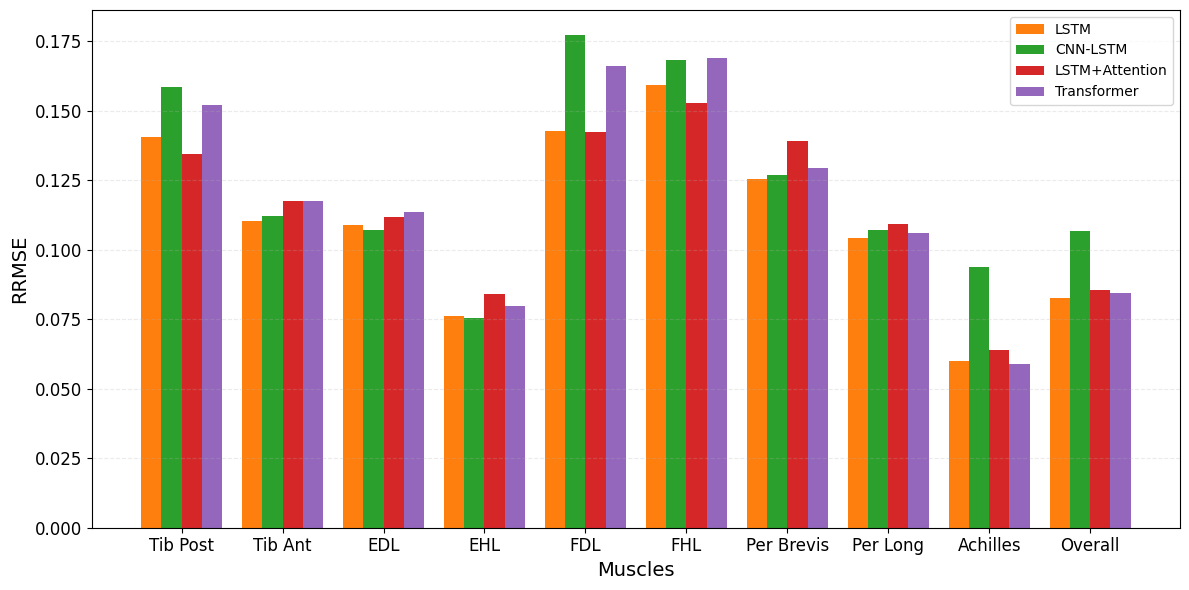

In [58]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], rrmse_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('RRMSE', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.tight_layout()
plt.show()

In [59]:
print(mae_muscle_dict)

{'LSTM': [77.93544191288672, 40.363261788797175, 12.352018044400134, 1.8945850312396644, 3.667890101738794, 17.089315129584392, 9.625610005275343, 29.630360075882233, 164.26761959339365, 0.056027752872394095], 'CNN-LSTM': [89.80363429730431, 43.0780490644502, 11.510774146149197, 1.7221775899572844, 4.763839591969552, 18.848460917038192, 9.896976275107425, 30.509689229500726, 281.1154354534411, 0.0771344346437337], 'LSTM+Attention': [74.86045765517727, 45.171958817248274, 13.70435595857239, 2.2939497686422357, 3.696977136487029, 16.77555833020849, 11.564589982101312, 32.62913667755531, 190.66077402848413, 0.06144980893030676], 'Transformer': [82.27448703734166, 43.25125994301459, 13.825769908114076, 1.9668558117326822, 4.340132672120507, 18.039339963996547, 9.732280613625726, 30.576781694095356, 175.07861200922778, 0.05952285920914329]}


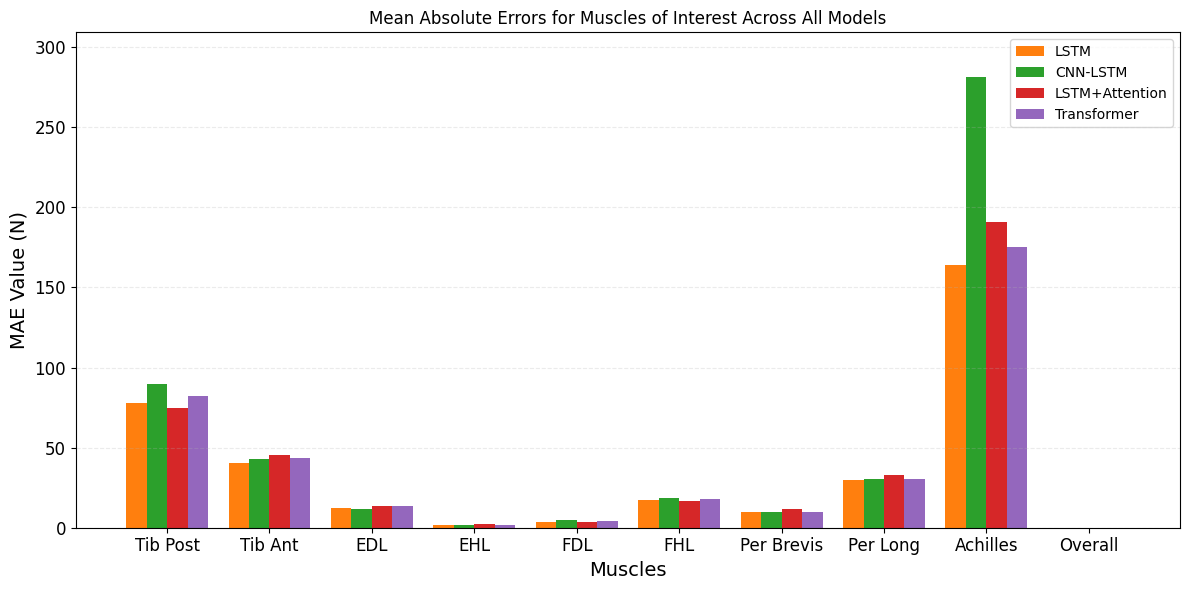

In [60]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], mae_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('MAE Value (N)', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(max(v) for v in mae_muscle_dict.values()) * 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.title('Mean Absolute Errors for Muscles of Interest Across All Models')
plt.tight_layout()
plt.show()

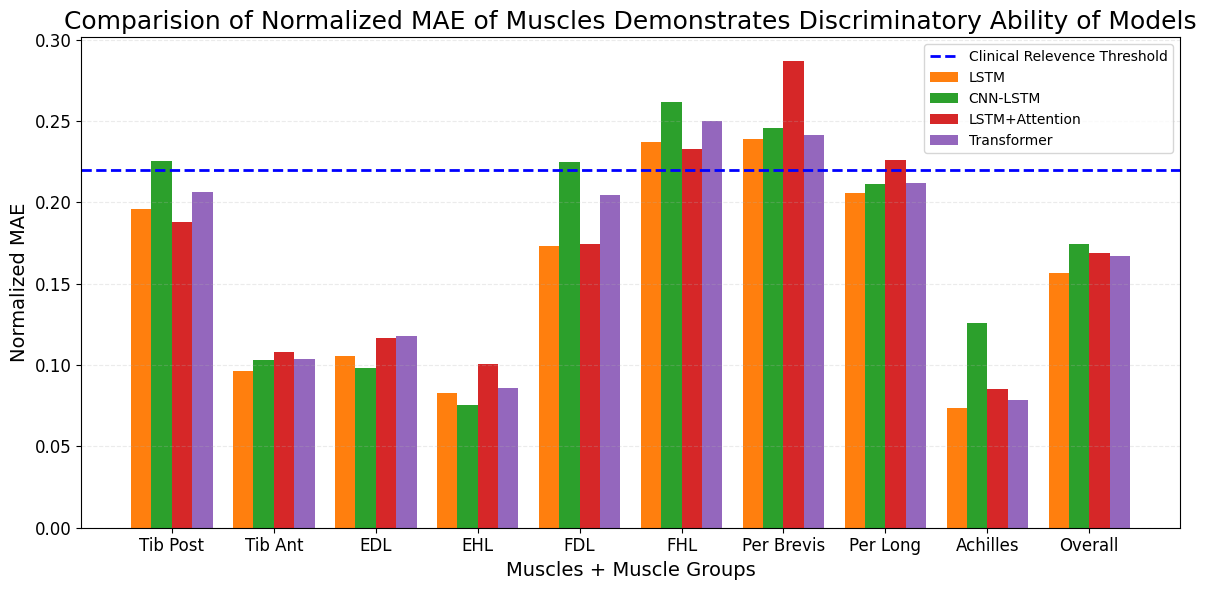

In [61]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], norm_mae_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.axhline(0.22, color='blue', linestyle='--', linewidth=2, label= 'Clinical Relevence Threshold')
plt.xlabel('Muscles + Muscle Groups', fontsize=14)
plt.ylabel('Normalized MAE', fontsize=14)
plt.title('Comparision of Normalized MAE of Muscles Demonstrates Discriminatory Ability of Models', fontsize = 18)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.tight_layout()
plt.show()